In [2]:
%matplotlib inline

from deepsea import *
from keras.models import load_model

import seaborn as sns
import matplotlib.pyplot as plt

from time import sleep
import sys

In [6]:
dsmodel = load_model("models/deepsea/weights-improvement-09-0.06-full.hdf5")

In [7]:
dsmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
valid_X, valid_Y, train_X, train_Y, test_X, test_Y = loaddata()

# Gradients test code (partial derivative)
gradient of the output with respect to inputs

In [12]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils.np_utils import to_categorical
import keras.backend as K

model = Sequential()
probs = model.add(Dense(2, activation='sigmoid', input_shape=[3]))
model.compile(optimizer='sgd', loss='binary_crossentropy')

In [13]:
gradients = model.optimizer.get_gradients(model.layers[-1].output.flatten()[0], model.layers[0].input) # gradient tensors

In [14]:
input_tensors = [model.inputs[0], # input data
                 model.model.sample_weights[0], # how much to weight each sample by
                 #model.model.targets[0], # labels
                 K.learning_phase(), # train or test mode
]

get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [15]:
inputs = [[[0, 1, 2]], # X
          [1], # sample weights
          #[[0]], # y
          0 # learning phase in TEST mode
]
get_gradients(inputs)

array([[-0.02419206, -0.01175148, -0.10234397]], dtype=float32)

# Gradients test code (multiple outputs)
gradient of the output with respect to inputs (jacobian using theano function)

In [16]:
import theano
import theano.tensor as T
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

model = Sequential([
    Dense(32, input_dim=4),
    Activation('relu'),
    Dense(2),
    Activation('sigmoid'),
])

model.compile(optimizer='sgd', loss='binary_crossentropy')

In [17]:
input_tensors = [model.inputs[0], # input data
                 model.model.sample_weights[0], # how much to weight each sample by
                 K.learning_phase(), # train or test mode
]

In [18]:
gradients = T.jacobian(model.layers[-1].output.flatten(), model.inputs)

In [19]:
get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [20]:
inputs = [[[0, 1, 2, 3], [0,1,2,3 ]], # X
          [1, 1], # sample weights
          0 # learning phase in TEST mode
]
grad = get_gradients(inputs)[0]

# Building model on the UCI iris data

Starting with simple one vs all classification

Loading iris data from UCI repo

In [24]:
X = np.array([[float(j) for j in i.rstrip().split(",")[:-1]] for i in open("data/uci_iris/iris.data").readlines()][:-1])

In [25]:
labels = list(set([i.rstrip().split(",")[-1] for i in open("data/uci_iris/iris.data").readlines()][:-1]))
labels.reverse()

In [26]:
Y = np.array([[1,0,0] for i in range(50)] + [[0,1,0] for i in range(50)] + [[0,0,1] for i in range(50)])

In [27]:
model = Sequential([
    Dense(3, input_dim=4),
    Activation('sigmoid'),
])
model.compile(optimizer='sgd', loss='binary_crossentropy')

Training and writing out the prediction

In [28]:
history = model.fit(X, Y,
          epochs=300, batch_size=10,
          validation_split=0.1, verbose=0)

In [29]:
pred = model.predict(X)
pred = np.transpose(pred)

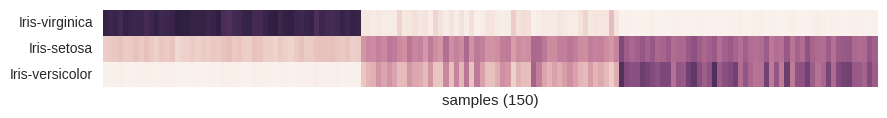

In [30]:
plt.figure(figsize=(10,1))
sns.heatmap(pred, cbar=False)
plt.xticks([],[])
plt.yticks([i+0.5 for i in range(3)], labels, rotation="horizontal")
plt.xlabel("samples (150)")

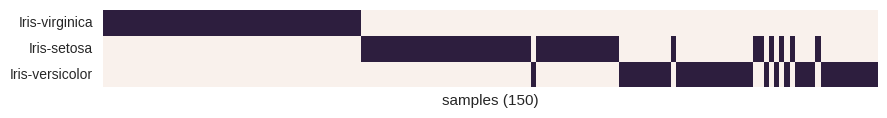

In [31]:
arg = np.argmax(pred, axis=0)
binary = np.zeros(pred.shape)
index = 0
for i in arg:
    binary[i, index] = 1
    index += 1
    
plt.figure(figsize=(10,1))
sns.heatmap(binary, cbar=False)
plt.xticks([],[])
plt.yticks([i+0.5 for i in range(3)], labels, rotation="horizontal")
plt.xlabel("samples (150)")

# Explaining the predictions with IntegratedGradients

The paper is published by researchers from Google (https://arxiv.org/pdf/1703.01365.pdf) and it is very simple to implement.   
We implement this in python and see how it works.

In [32]:
# creating samples needed for integrated gradient
def linear_ip(sample, reference=False, steps=50):
    if not(reference): reference = np.zeros(len(sample));
    ret = np.zeros(tuple([steps] +[i for i in sample.shape]))
    for f in range(len(sample)):
        for s in range(steps):
            ret[s, f] = reference[f]+(sample[f]-reference[f])*(s*1.0/steps)
    return np.array(ret), steps, np.array([(sample[f]-reference[f])*1.0/steps for f in range(len(sample))])

In [33]:
class integrated_gradients:
    
    def __init__(self, model):
        #load model
        self.model = model
        
        #load input tensors
        self.input_tensors = [model.inputs[0], # input data
                 model.model.sample_weights[0], # how much to weight each sample by
                 #model.model.targets[0], # labels
                 K.learning_phase()
                 ]
        
        # jacobian will break on a network with dropout
        gradients = T.jacobian(self.model.layers[-1].output.flatten(), self.model.inputs)        
        self.get_gradients = K.function(inputs=self.input_tensors, outputs=gradients)
        
    # using Jacobian
    def explain(self, sample):
        linear_interpolated_samples, steps, stepsize = linear_ip(sample)
        inputs = [linear_interpolated_samples, # X
          np.ones(steps+1), # sample weights
          #[np.ones(steps+1)], # y
          0 # learning phase in TEST mode
          ]
        
        
        insta_gradients = self.get_gradients(inputs)[0]
        explanation = np.zeros((self.model.output._keras_shape[1], len(sample)))
        
        #print insta_gradients
        for f in range(self.model.output._keras_shape[1]):
            for i in range(steps):
                explanation[f,:] += np.multiply(insta_gradients[i*3+f, i], stepsize)
                #print insta_gradients[i*3+f, i]
        
        return explanation

In [34]:
class integrated_gradients2:
    
    def __init__(self, model, outchannels=False):
        #load model
        self.model = model
        
        #load input tensors
        self.input_tensors = [model.inputs[0], # input data
                 model.model.sample_weights[0], # how much to weight each sample by
                 #model.model.targets[0], # labels
                 K.learning_phase()
                 ]
        self.get_gradients = {}
        
        
        if not outchannels:
            outchannels = range(self.model.output._keras_shape[1])
        
        outnum = len(outchannels)
            
        for f in outchannels:
            gradients = model.optimizer.get_gradients(model.layers[-1].output.flatten()[f], model.inputs)
            self.get_gradients[f] = K.function(inputs=self.input_tensors, outputs=gradients)
            
            sys.stdout.write('\r')
            sys.stdout.write(str(int((f+1)*1.0/outnum*1000)*1.0/10)+"%")
            sys.stdout.flush()
        
    # using partial derivative.
    def explain(self, sample, outf=0):
        linear_interpolated_samples, steps, stepsize = linear_ip(sample)
        
        ###################################################################
        # Potentially use scan or re-implement jacobian without assertion #
        ###################################################################
        
        explanation = np.zeros(sample.shape)
        
        for i in range(steps):
            _input = [linear_interpolated_samples[i:i+1,:], # X
              [1], # sample weights
              #[np.ones(steps+1)], # y
              0 # learning phase in TEST mode
              ]
            insta_gradients = self.get_gradients[outf](_input)[0]
            explanation += np.multiply(insta_gradients[0,:], stepsize)
            
        return explanation

In [35]:
ig = integrated_gradients(model)

In [36]:
ig.explain(X[0])

array([[ 0.40449531,  0.34010589, -0.35024733, -0.02533489],
       [-0.55790681,  0.01223616,  0.14197929,  0.01845119],
       [-0.34767518, -0.20587542,  0.12733001,  0.02025959]])

In [37]:
ig2 = integrated_gradients2(model)

100.0%

In [38]:
ig2.explain(X[0], 0)

array([ 0.40449531,  0.34010589, -0.35024733, -0.02533489])

In [39]:
data = np.zeros((12,150))
for i in range(len(X)):
    data[:, i] += ig.explain(X[i]).reshape((12,))

In [40]:
data2 = np.zeros((4,150))
for i in range(len(X)):
    data2[:, i] += ig2.explain(X[i], 0).reshape((4,))

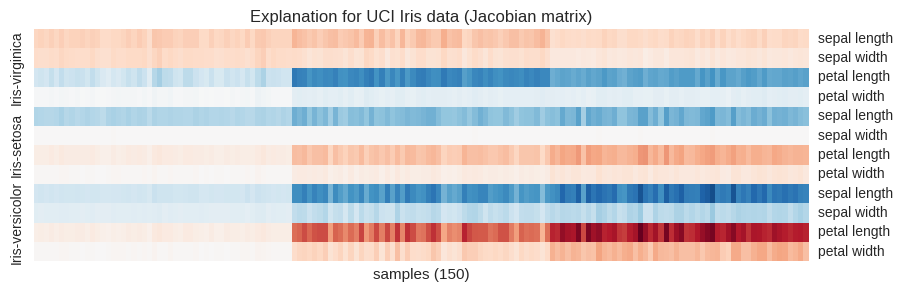

In [41]:
plt.figure(figsize=(10,3))
ax = sns.heatmap(data, cbar=False)
plt.xticks([],[])
plt.yticks([i*4+2 for i in range(3)], labels)
plt.xlabel("samples (150)")
ax2 = ax.twinx()
ax2.set_yticks([i+0.5 for i in range(12)])
ax2.set_yticklabels(["petal width", "petal length", "sepal width", "sepal length"]*3)
ax2.set_ylim(0,12)
ax2.grid(False)
plt.title("Explanation for UCI Iris data (Jacobian matrix)")

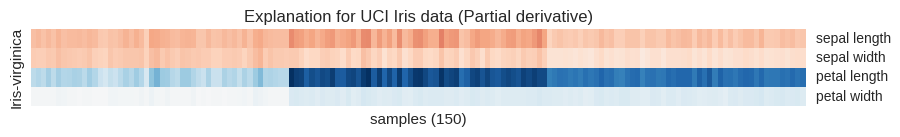

In [42]:
plt.figure(figsize=(10,1))
ax = sns.heatmap(data2, cbar=False)
plt.xticks([],[])
plt.yticks([],[])
plt.ylabel(labels[-1])
plt.xlabel("samples (150)")
ax2 = ax.twinx()
ax2.set_yticks([i+0.5 for i in range(4)])
ax2.set_yticklabels(["petal width", "petal length", "sepal width", "sepal length"])
ax2.set_ylim(0,4)
ax2.grid(False)
plt.title("Explanation for UCI Iris data (Partial derivative)")

In [43]:
np.sum(data2, axis=0)

array([ 0.36901897,  0.34210572,  0.35533588,  0.32003756,  0.36962551,
        0.35453969,  0.3433084 ,  0.35238702,  0.31337414,  0.34077107,
        0.37490266,  0.3319442 ,  0.34445517,  0.36006884,  0.40301114,
        0.39155316,  0.38670036,  0.3645218 ,  0.36514083,  0.36602791,
        0.34383477,  0.35740237,  0.38846775,  0.30026525,  0.27959204,
        0.31812593,  0.32647276,  0.36286956,  0.36840575,  0.31529965,
        0.31412171,  0.35515881,  0.38468068,  0.39446544,  0.34077107,
        0.37327067,  0.38537471,  0.34077107,  0.33441836,  0.3558115 ,
        0.37050763,  0.28521306,  0.34448439,  0.31678383,  0.30830312,
        0.33109665,  0.361414  ,  0.33988476,  0.37242079,  0.35885028,
       -0.55544822, -0.55850801, -0.575015  , -0.56088635, -0.57222919,
       -0.57481154, -0.57323194, -0.47548596, -0.56212405, -0.55265752,
       -0.52576629, -0.55364264, -0.53766946, -0.57858455, -0.48221602,
       -0.54083487, -0.57732173, -0.53437855, -0.58211012, -0.53

# Comparing the result with Shap

In [44]:
from shap import KernelExplainer, DenseData, visualize, initjs
from sklearn import datasets,neighbors
from numpy import random, arange

# print the JS visualization code to the notebook
initjs()

# train a k-nearest neighbors classifier on a random subset 
iris = datasets.load_iris()
random.seed(2)
inds = arange(len(iris.target))
random.shuffle(inds)
knn = neighbors.KNeighborsClassifier()
knn.fit(iris.data, iris.target == 0)

# use Shap to explain a single prediction
background = DenseData(iris.feature_names, iris.data[inds[:100],:]) # name the features
explainer = KernelExplainer(knn.predict, background, nsamples=100)
x = iris.data[inds[102:103],:]
visualize(explainer.explain(x))

AttributeError: 'list' object has no attribute 'shape'

# Explaning the deepsea model with integrated gradients

We are looking at estimated Shaply values assigned to the central 400-600bp of 1000bp windows.

In [45]:
prediction = dsmodel.predict(valid_X)

In [46]:
ig2 = integrated_gradients2(dsmodel, [0])

100.0%

In [47]:
indexes = [i for i in range(len(valid_Y[:,0])) if valid_Y[:,0][i] == 1 and prediction[:, 0][i] > 0.4]

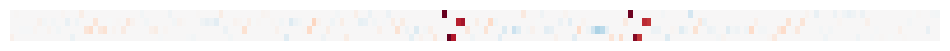

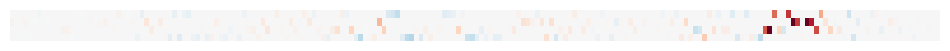

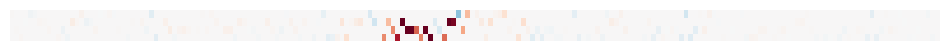

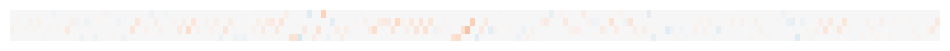

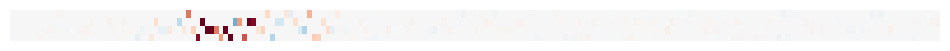

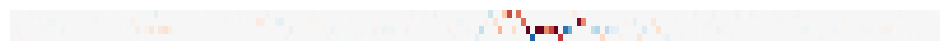

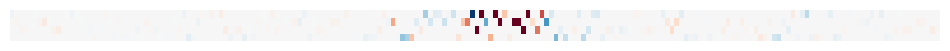

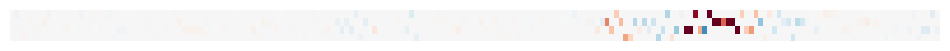

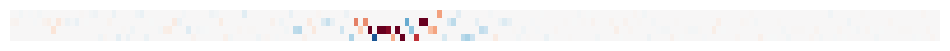

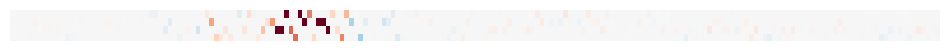

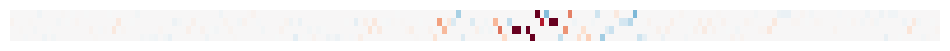

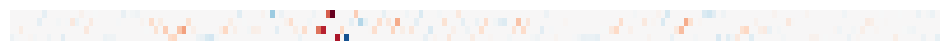

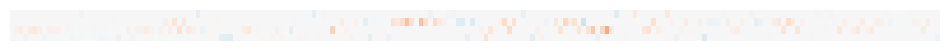

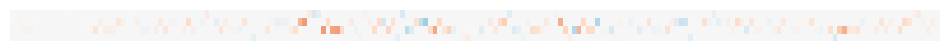

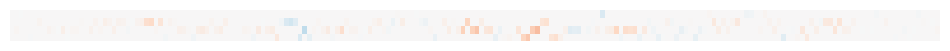

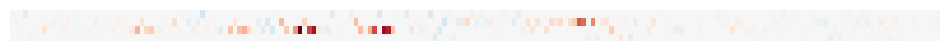

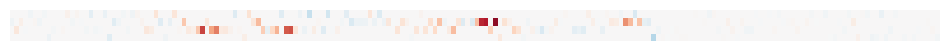

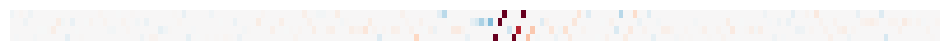

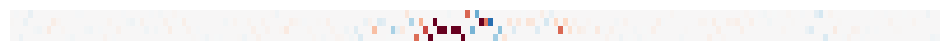

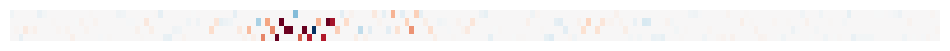

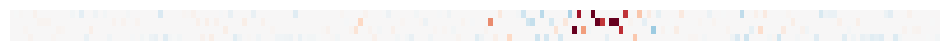

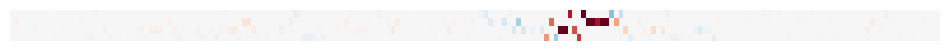

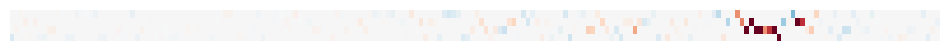

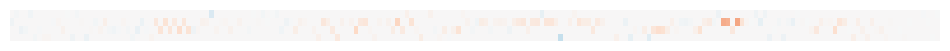

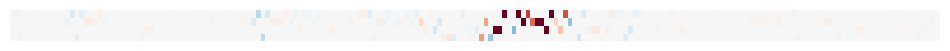

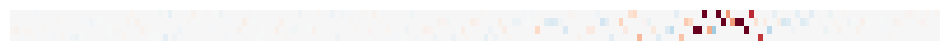

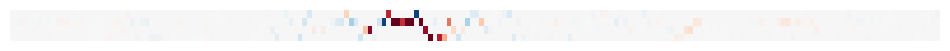

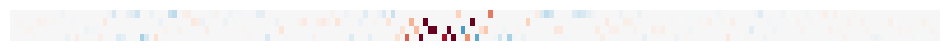

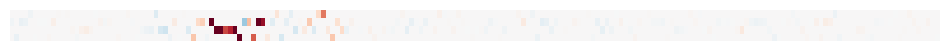

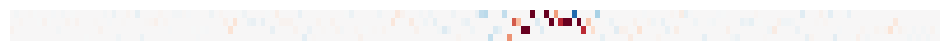

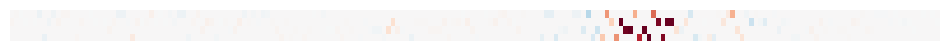

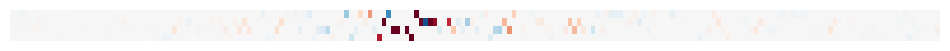

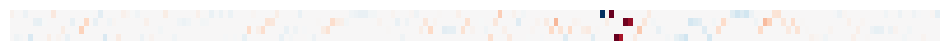

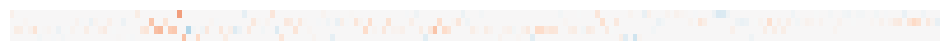

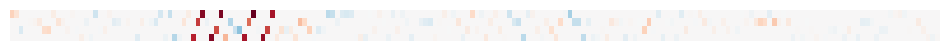

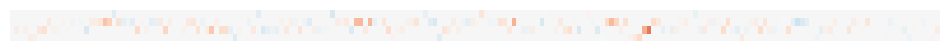

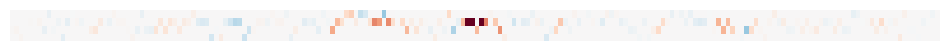

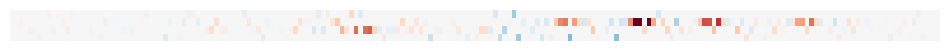

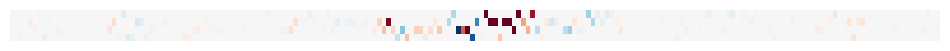

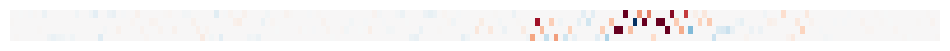

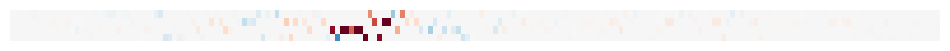

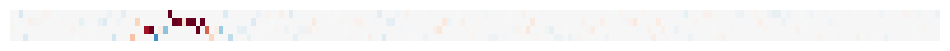

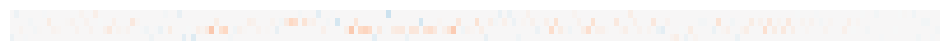

In [48]:
for index in indexes:
    ex = ig2.explain(valid_X[index])
    plt.figure(figsize=(12,0.4))
    sns.heatmap(np.transpose(ex[0,400:600]), cbar=False, vmin=-0.05, vmax=0.05)
    plt.yticks([],[])
    plt.xticks([],[])
    plt.show()